# Video embedding using the Barlow Twins method

This notebook applies several augmentations to an input video and implements self-supervised learning using the Barlow Twins method. The data contains two hours of nesting behaviour. 


## 1. Importing the package 

In [1]:
import video_embedding as ve

## 2. Loading the video and applying augmentations

**NOTE: The current model uses the BatchNorm module of pytorch. This only allows for batch sizes larger than 1. Users should use LayerNorm for btach sizes of 1.**

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
batch_size = 2

image_size = 216
duration = 16 #30
clip_size = 30 #90
num_workers = 1


video_list = ["example_video.mp4"]
print(len(video_list))

augmentator = ve.VideoAugmentator(duration=duration, crop_size=image_size, multiplier=6)
dataset = ve.VidioDataset(video_list, augmentator, clip_size, temporal_downsample=2)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

1


/home/dattalab/miniconda3/envs/video_embedding/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [3]:
import numpy as np
x_one, x_two = next(iter(dataloader))
x_one = ve.untransform_video(x_one)
x_two = ve.untransform_video(x_two)
ve.play_videos(np.concatenate([x_one[:4],x_two[:4]]), 2, 4)

## 3.Implementing the model

In [4]:
from torchvision import models
model = models.video.s3d(weights=models.video.S3D_Weights.DEFAULT)
model.classifier = torch.nn.Identity()

In [5]:
import os
feature_size = 1024
epochs = 1500
steps_per_epoch = 500
checkpoint_dir = 'checkpoint_directory'
loss_log = os.path.join(checkpoint_dir, "log_loss.txt")

learner = ve.BarlowTwins(model, feature_size).to('cuda').train()
opt = torch.optim.Adam(learner.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
if not os.path.exists(loss_log):
    open(loss_log, "w").close()

In [6]:
ve.train(
    learner=learner,
    model=model,
    optimizer=opt,
    scheduler=scheduler,
    dataloader=dataloader,
    start_epoch=0,
    epochs=10,
    steps_per_epoch=100,
    checkpoint_dir="./checkpoint_directory",
    loss_log_path="./log_loss.txt",
    device="cuda"
)

Epoch 1/10:   0%|                                                                                                                                                                | 0/100 [00:00<?, ?batch/s]/home/dattalab/miniconda3/envs/video_embedding/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Epoch 2/10:   0%|                                                                                                                                                                | 0/100 [00:00<?, ?batch/s]/home/dattalab/miniconda3/envs/video_embedding/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Epoch 2/10:   1%|█▍                                               

KeyboardInterrupt: 

In [45]:
#old code
import os

checkpoint_path = f'{checkpoint_dir}/checkpoint_1.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
learner.load_state_dict(checkpoint['learner_state_dict'])
start_epoch = checkpoint['epoch'] + 1

RuntimeError: Error(s) in loading state_dict for BarlowTwins:
	Unexpected key(s) in state_dict: "bn.running_mean", "bn.running_var", "bn.num_batches_tracked", "projector.layer1.1.weight", "projector.layer1.1.bias", "projector.layer1.1.running_mean", "projector.layer1.1.running_var", "projector.layer1.1.num_batches_tracked", "projector.layer2.1.weight", "projector.layer2.1.bias", "projector.layer2.1.running_mean", "projector.layer2.1.running_var", "projector.layer2.1.num_batches_tracked", "encoder.1.layer1.1.weight", "encoder.1.layer1.1.bias", "encoder.1.layer1.1.running_mean", "encoder.1.layer1.1.running_var", "encoder.1.layer1.1.num_batches_tracked", "encoder.1.layer2.1.weight", "encoder.1.layer2.1.bias", "encoder.1.layer2.1.running_mean", "encoder.1.layer2.1.running_var", "encoder.1.layer2.1.num_batches_tracked". 

## 4.Inspecting model 

In [9]:
import glob 
from vidio.read import OpenCVReader
video_paths = ['/home/dattalab/video-embedding/example_video.mp4']
lengths = [len(OpenCVReader(p)) for p in video_paths]



In [29]:
import tqdm
paths = []
starts = []
embeddings = []

for i in tqdm.trange(500):
    ix = np.random.choice(len(video_paths))
    path = video_paths[ix]
    start = np.random.randint(lengths[ix]-60)
    clip = ve.get_clip(path, start, duration=60)[::2]
    clip = ve.center_crop(clip, image_size)
    X = ve.transform_video(clip)[None]
    embedding = model(X.to("cuda"))
    embeddings.append(embedding.detach().cpu().numpy()[0])
    starts.append(start)
    paths.append(path)

import joblib
embeddings = np.array(embeddings)
joblib.dump((paths, starts, embeddings), 'tmp-v10.p')


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:30<00:00,  5.51it/s]


['tmp-v10.p']

In [30]:
from umap import UMAP
from sklearn.decomposition import PCA

Xpca = PCA(n_components=20).fit_transform(embeddings)
xy = UMAP(n_components=2, n_neighbors=50).fit_transform(embeddings)

/home/dattalab/miniconda3/envs/video_embedding/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [44]:
# xy_emb = xy
# Xpca_emp = Xpca

In [31]:
from sklearn.cluster import KMeans

n_clusters = 8
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

In [33]:
rois = ['A','B','C','D']
roi_ix = np.array([rois.index(f.split('.')[-1]) for f in paths])

ValueError: 'mp4' is not in list

In [24]:
import numpy as np
import os

rois = ['A','B','C','D']

def extract_roi_label(path: str) -> str:
    parts = os.path.basename(path).split('.')
    for p in parts:
        if p in rois:
            return p
    raise ValueError(f"No ROI label in {path!r}")

roi_ix = np.array([rois.index(extract_roi_label(f)) for f in paths])


ValueError: No ROI label in '/home/dattalab/video-embedding/example_video.mp4'

In [25]:
import matplotlib as plt

fig,axs = plt.subplots(2,int(np.ceil((n_clusters+2)/2)), sharey=True)
axs.flat[0].scatter(*xy.T,s=1,c=roi_ix, cmap=plt.cm.jet)
axs.flat[1].scatter(*xy.T,s=1,c=np.array(starts))
for i in range(n_clusters):
    axs.flat[i+2].scatter(*xy.T,s=1,c=clus==i)
for ax in axs.flat:
    ax.axis('off')
fig.set_size_inches((10,4))

AttributeError: module 'matplotlib' has no attribute 'subplots'

In [27]:
n_examples_per_cluster = 4

clips = []
for i in range(n_clusters):
    ixs = np.random.choice((clus==i).nonzero()[0], n_examples_per_cluster, replace=False)
    for ii in ixs:
        clips.append(ve.get_clip(paths[ii], starts[ii], duration=60)[::2])
ve.play_videos(np.stack(clips), n_clusters, n_examples_per_cluster)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [23]:
from sklearn.cluster import KMeans

n_clusters = 16
clus = KMeans(n_clusters=n_clusters).fit_predict(Xpca)

/home/csw14/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
o = np.argsort(np.argsort([np.array(starts)[clus==i].mean() for i in range(n_clusters)]))
clus = o[clus]

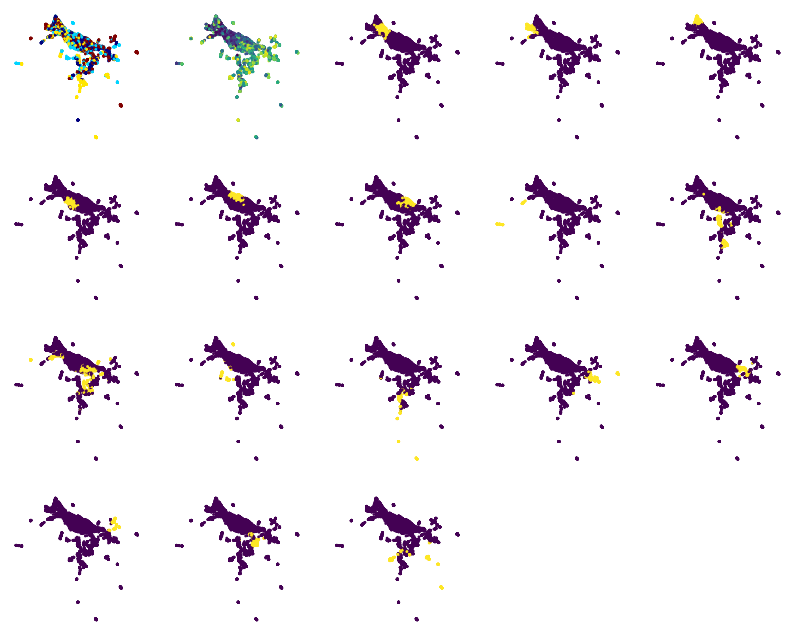

In [28]:
fig,axs = plt.subplots(4,int(np.ceil((n_clusters+2)/4)), sharey=True)
axs.flat[0].scatter(*xy.T,s=1,c=roi_ix, cmap=plt.cm.jet)
axs.flat[1].scatter(*xy.T,s=1,c=np.array(starts))
for i in range(n_clusters):
    axs.flat[i+2].scatter(*xy.T,s=1,c=clus==i)
for ax in axs.flat:
    ax.axis('off')
fig.set_size_inches((10,8))

In [29]:
n_examples_per_cluster = 4

clips = []
for i in range(n_clusters):
    ixs = np.random.choice((clus==i).nonzero()[0], n_examples_per_cluster, replace=False)
    for ii in ixs:
        clips.append(get_clip(paths[ii], starts[ii], duration=60)[::2])
ve.play_videos(np.stack(clips), n_clusters, n_examples_per_cluster)

## 5.Running inference on video

In [34]:
import glob

exclude = [
    '24_9_16_fake_TRAP_pilot.rig2.A.cropped.mp4',
    '24_9_16_fake_TRAP_pilot.rig2.D.cropped.mp4',
    '24_9_18_fake_TRAP_pilot.rig2.A.cropped.mp4',
]
video_list = [f for f in glob.glob('../../cropped_videos/*') if f.split('/')[-1] not in exclude]

cmd = 'sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py {}"""'
for video in video_list:
    print(cmd.format(video))


sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py ../../cropped_videos/24_9_10_fake_TRAP_pilot.rig2.A.cropped.mp4"""
sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py ../../cropped_videos/24_9_10_fake_TRAP_pilot.rig2.B.cropped.mp4"""
sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py ../../cropped_videos/24_9_10_fake_TRAP_pilot.rig2.C.cropped.mp4"""
sbatch -p gpu_quad -t 30:00 --mem 2GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_barlowtwins_X3D_on_crops-v10.py ../../cropped_videos/24_9_10_fake_TRAP_pilot.rig2.D.cropped.mp4"""
sbatch -p gpu_quad -

### 5.2 Running inference on clips chosen for annotation (across epochs)

In [8]:
from torchvision import models

model = models.video.s3d(weights=models.video.S3D_Weights.DEFAULT)
model.classifier = torch.nn.Identity()
model = model.to("cuda").eval()

image_size = 216
feature_size = 1024
checkpoint_dir = 'barlowtwins_X3D_on_crops_v10'
loss_log = os.path.join(checkpoint_dir, "log_loss.txt")

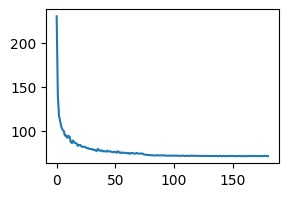

In [5]:
plt.plot(np.loadtxt(loss_log, delimiter="\t")[:,1])
plt.gcf().set_size_inches((3,2))

In [28]:
import json, h5py
annos_path = "../../annotations/24_10_2_cropped_2sec_v1.json"
annotations = json.load(open(annos_path,"r"))

In [ ]:
for epoch in [1, 10, 50, 150]:
    checkpoint_path = f'{checkpoint_dir}/checkpoint_{epoch}.pth'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    save_path = annos_path.replace(".json", f".embeddings.epoch{epoch}.h5")
    with h5py.File(save_path, "w") as h5:
        embeddings = h5.create_dataset("embeddings", (len(annotations), feature_size))
        for i in tqdm.trange(len(annotations)):
            path, start, end, _ = annotations[i]
            clip = np.stack(OpenCVReader("../../"+path)[start:end][::2])
            clip = center_crop(clip, image_size)
            X = transform_video(clip)[None]
            embedding = model(X.to("cuda")).detach().cpu().numpy()[0]
            embeddings[i] = embedding

/tmp/ipykernel_266059/4193309314.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
 27%|██▋       | 1368/5000 [04:10<10:43,  5.65i

## 6. Visualizing results

In [1]:
import h5py
from umap import UMAP
from sklearn.decomposition import PCA

annos_path = "../../annotations/24_10_2_cropped_2sec_v1.json"

all_Xpca = []
all_umap = []
for epoch in [1, 10, 50, 150]:
    print(epoch)
    save_path = annos_path.replace(".json", f".embeddings.epoch{epoch}.h5")
    with h5py.File(save_path, 'r') as h5:
        embeddings = h5["embeddings"][()]
        Xpca = PCA(n_components=20).fit_transform(embeddings)
        xy = UMAP(n_components=2, n_neighbors=50).fit_transform(embeddings) 
        all_Xpca.append(Xpca)
        all_umap.append(xy)

/home/csw14/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1
10
50
150


In [5]:
import numpy as np
import json
import matplotlib.pyplot as plt

annotations = json.load(open(annos_path, "r"))
starts = np.array([start for (path, start, end, labels) in annotations])
all_labels = sorted(set(sum([labels for (path, start, end, labels) in annotations], [])))
has_label = np.array([[l in labels for _,_,_,labels in annotations] for l in all_labels])
use_labels_ix = (has_label.sum(1) >= 10).nonzero()[0]

rois = ['A','B','C','D']
paths = [path for (path, start, end, labels) in annotations]
roi_ix = np.array([rois.index(f.split('.')[-3]) for f in paths])

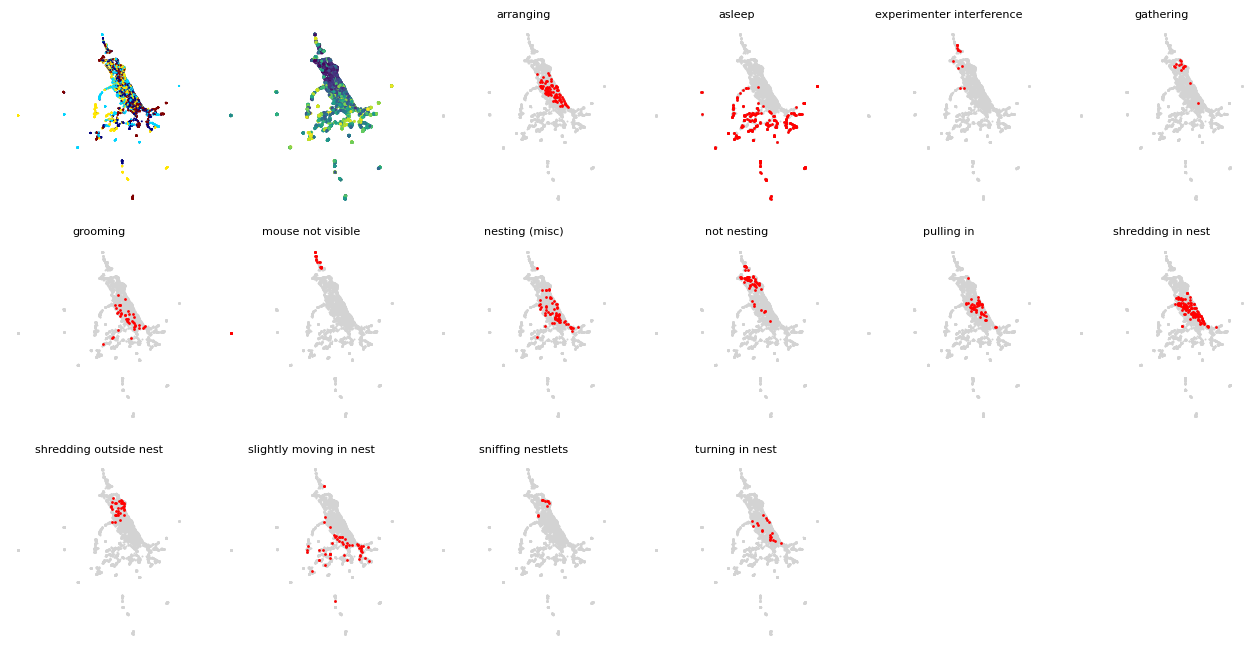

In [21]:
xy = all_umap[-1]
num_plots = len(use_labels_ix) + 2
num_cols = 6
fig,axs = plt.subplots(int(np.ceil(num_plots / num_cols)), num_cols)
axs.flat[0].scatter(*xy.T, c=roi_ix, cmap=plt.cm.jet, s=2, linewidth=0)
axs.flat[1].scatter(*xy.T, c=starts, s=5, linewidth=0)
for ax,i in zip(axs.flat[2:], use_labels_ix):
    ax.scatter(*xy.T, c='lightgray', s=2, linewidth=0)
    ax.scatter(*xy[has_label[i]].T, c='r', s=4, linewidth=0)
    ax.set_title(all_labels[i], fontsize=8)
for ax in axs.flat:
    ax.axis("off")
fig.set_size_inches((16, 16/axs.shape[1]*axs.shape[0]))

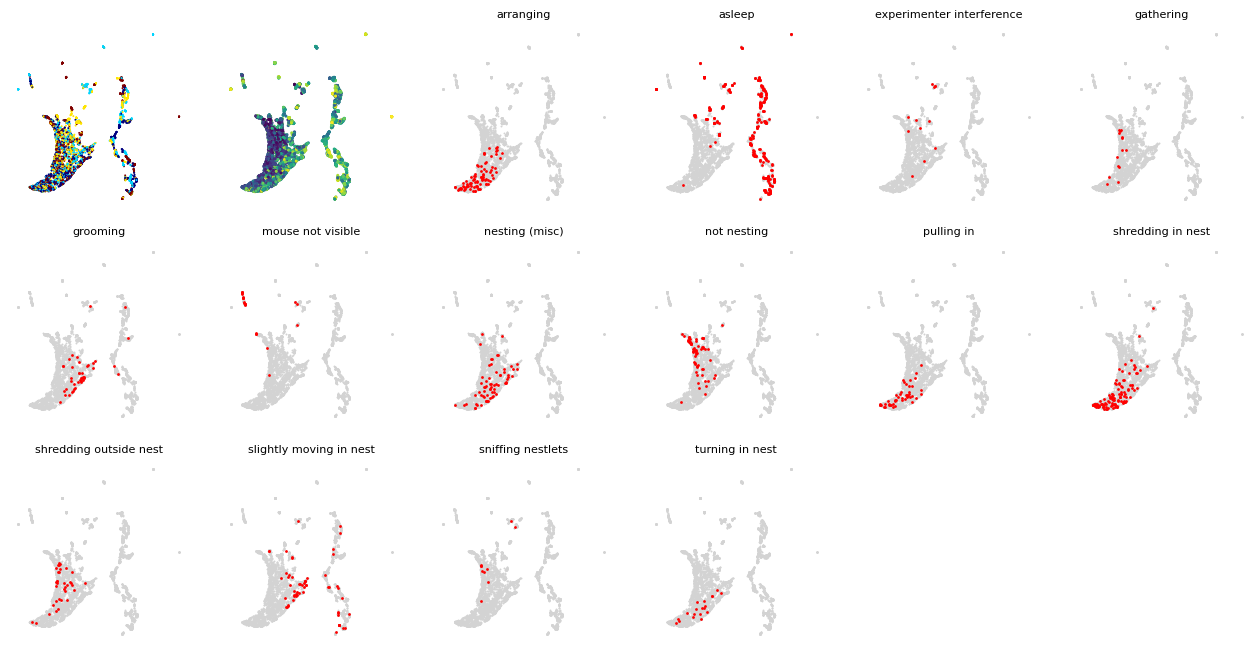

In [22]:
xy = all_umap[0]
num_plots = len(use_labels_ix) + 2
num_cols = 6
fig,axs = plt.subplots(int(np.ceil(num_plots / num_cols)), num_cols)
axs.flat[0].scatter(*xy.T, c=roi_ix, cmap=plt.cm.jet, s=2, linewidth=0)
axs.flat[1].scatter(*xy.T, c=starts, s=5, linewidth=0)
for ax,i in zip(axs.flat[2:], use_labels_ix):
    ax.scatter(*xy.T, c='lightgray', s=2, linewidth=0)
    ax.scatter(*xy[has_label[i]].T, c='r', s=4, linewidth=0)
    ax.set_title(all_labels[i], fontsize=8)
for ax in axs.flat:
    ax.axis("off")
fig.set_size_inches((16, 16/axs.shape[1]*axs.shape[0]))